# Expanding returns

```{note}
The code below might need to be modified to work as of Feb 2023. [The fix is here.](https://github.com/LeDataSciFi/ledatascifi-2023/issues/6)
```

## The problem

You know the charts that show cumulative returns if you'd bought and held a stock since some long ago date? Let's make one!

This is called "expanding returns" because you get the total returns from day 0 to day N, then from day 0 to day N+1, and so on; the window is expanding instead of having a fixed number of units or containing a specific increment of time.

## Download the returns

We need a dataset with firm, date, and the daily return. Let's build it:

In [1]:
#!pip install pandas_datareader # uncomment and run this ONE TIME ONLY to install pandas data reader

In [2]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr # you might need to install this (see above)
from datetime import datetime

# choose your firms and dates 
stocks = ['SBUX','AAPL','MSFT']
start  = datetime(1980, 1, 1)
end    = datetime(2022, 7, 31)

```{tip}
The code in the next block is explained more thoroughly in `handouts/factor_loading_simple.ipynb` in the textbook repo because that file prints the status of the data throughout. Looking at this might help.
```

In [3]:
# download stock prices 
# here, from yahoo: not my fav source, but quick. 
# we need to do some data manipulation to get the data ready 
stock_prices = pdr.get_data_yahoo(stocks, start=start, end=end)
stock_prices = stock_prices.filter(like='Adj Close') # reduce to just columns with this in the name
stock_prices.columns = stocks # put their tickers as column names

# refmt from wide to long
stock_prices = stock_prices.stack().swaplevel().sort_index().reset_index()
stock_prices.columns = ['Firm','Date','Adj Close']

# add return var = pct_change() function compares to prior row
# EXCEPT: don't compare for first row of one firm with last row of prior firm!
# MAKE SURE YOU CREATE THE VARIABLES WITHIN EACH FIRM - use groupby
stock_prices['ret'] = stock_prices.groupby('Firm')['Adj Close'].pct_change()
stock_prices['ret'] = stock_prices['ret'] 
stock_prices.head(15)

,Firm,Date,Adj Close,ret
0,AAPL,1980-12-12,0.100040,NaN
1,AAPL,1980-12-15,0.094820,-0.052171
2,AAPL,1980-12-16,0.087861,-0.073398
3,AAPL,1980-12-17,0.090035,0.024751
4,AAPL,1980-12-18,0.092646,0.028992
5,AAPL,1980-12-19,0.098300,0.061029
6,AAPL,1980-12-22,0.103084,0.048670
7,AAPL,1980-12-23,0.107434,0.042199
8,AAPL,1980-12-24,0.113088,0.052628
9,AAPL,1980-12-26,0.123527,0.092310


## Getting the expanding returns

Notice that this dataset has the simple return for a period, not the gross returns (defined [here](05a_compounding)). 

To compute $R_i[0,T]$ for all firms $i$ and each time $T$ in the dataset, you're going to need to use groupby. You have two equivalent options from there: 

1. For each firm, get the `cumprod()` of the gross return over its time series.
    ```python
    df.assign(R=1+df['r']).groupby('firm')['R'].cumprod()
    ```
1. For each firm, take the product of $1+r$ for all prior periods using the expanding window functionality.
    ```python
    df.groupby('firm')['r'].expanding().apply(lambda x: np.prod(1+x))
    ```

Which you choose is up to you, but in my testing, the `cumprod` approach is 2.5x faster. 

In [4]:
stock_prices['cumret'] = \
(
    stock_prices
    .assign(ret=1+stock_prices['ret'])
    .groupby('Firm')
    ['ret']
    .cumprod()
)

## Plotting the total returns

If only we [could turn back time. ](https://www.youtube.com/watch?v=9n3A_-HRFfc)

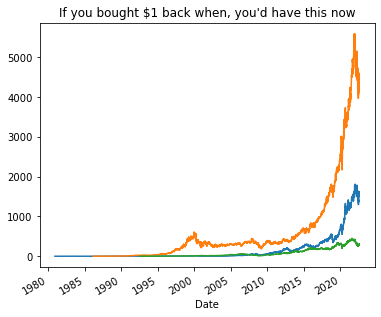

In [5]:
(stock_prices.set_index('Date').groupby('Firm')['cumret']
 .plot(title="If you bought $1 back when, you'd have this now",
       figsize=(6,5))
);